# Fraud Transaction Detection with Random Forest Classifier 

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import MinMaxScaler, StandardScaler 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, log_loss
import seaborn as sns  
import matplotlib.pyplot as plt

In [2]:
# Define Custom Bar Plot 
def custom_bar_plot(df, target_column, title='Distribution of the Dataset'):
    class_distribution = df[target_column].value_counts()
    total_count = class_distribution.sum()
    
    plt.figure(figsize=(7, 3.5))
    colors = plt.cm.tab20(np.linspace(0, 1, len(class_distribution)))
    colors = list(colors)
    if len(colors) > 1:
        colors[1] = 'orange'
    
    bars = class_distribution.plot(kind='bar', color=colors)
    plt.xlabel('Class')
    plt.ylabel('Data points per Class')
    plt.title(title)

    # Set the y-axis limit to cover the original values
    plt.ylim(0, class_distribution.max()+10**5)

    # Add value labels (percentage only) on top of each bar in vertical orientation
    for i, bar in enumerate(bars.patches):
        height = bar.get_height()
        percentage = (height / total_count) * 100
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{percentage:.4f}%',
                 ha='center', va='bottom', rotation=90)
    plt.show()

In [3]:
# Load Dataset
# Load creditcard dataset from Kaggle [link: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud]
file_path = 'C:\\Users\\mraza\\creditcard.csv'
creditcard__dataset= pd.read_csv(file_path)
print('Creditcard Dataset: ')
display(creditcard__dataset.head())
print('Creditcard Dataset Shape:',creditcard__dataset.shape)

Creditcard Dataset: 


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Creditcard Dataset Shape: (284807, 31)


Class distribution in creditcard Dataset:
 0    284315
1       492
Name: Class, dtype: int64


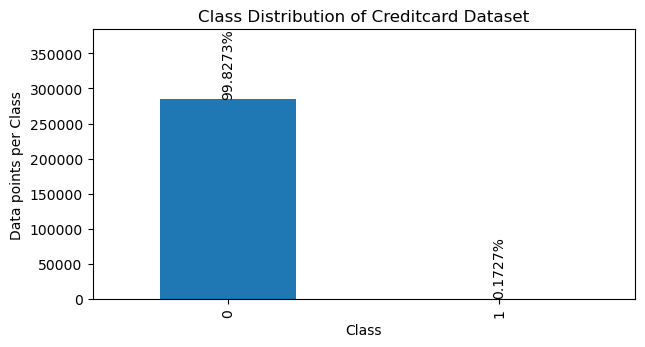

In [4]:
# Visualization of Class Distribution in the creditcard Dataset 
print('Class distribution in creditcard Dataset:\n', creditcard__dataset['Class'].value_counts())
custom_bar_plot(creditcard__dataset,'Class', 'Class Distribution of Creditcard Dataset')

In [5]:
# Cleaning Dataset for Analysis (Nan Value, Infinite Values)
#Nan Value 
creditcard__dataset = creditcard__dataset.dropna().reset_index(drop = True)
print('Creditcard Dataset:')
display(creditcard__dataset.head())
print('Creditcard Dataset Shape:',creditcard__dataset.shape)

# Infinite Values 
inf_mask= np.isinf(creditcard__dataset) # Create a boolean mask
inf_counts= inf_mask.sum()# Count per column
print("\nNumber of infinite values per column in creditcard dataset:")
print(inf_counts)

Creditcard Dataset:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Creditcard Dataset Shape: (284807, 31)

Number of infinite values per column in creditcard dataset:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [6]:
# Figure out Data Types in the Dataset
pd.set_option('display.max_rows', None)
print(creditcard__dataset.dtypes)
pd.reset_option('display.max_rows')

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object


### Note: There are no categorical features (of object type) in the input of the Dataset; therefore, there is no need to apply "one-hot encoding" to the input features.

X_train:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
2557,2105.0,-2.289565,-0.480260,0.818685,-1.706423,0.822102,-1.660326,0.944047,-0.541765,1.323156,...,-0.831985,-0.210837,0.914737,0.867888,0.422969,0.310584,-0.781488,0.392241,-0.147757,1.00
247823,153702.0,-0.313717,-4.064342,-3.398445,0.704011,0.101662,1.529848,1.551670,-0.036774,0.015829,...,2.142593,0.853186,-0.091941,-0.936215,-0.833081,-0.498728,0.651183,-0.290331,0.110360,1194.28
152342,97283.0,-1.809763,-0.567439,2.265186,-0.960318,-1.212537,1.516493,-1.417176,0.903421,1.961027,...,-0.554004,-0.509915,-0.424978,-0.268621,0.010121,0.466862,0.835540,-0.062385,0.088079,75.00
103385,68628.0,1.192319,0.178575,0.141491,0.459628,-0.049959,-0.112122,-0.163883,0.155740,-0.067566,...,-0.149985,-0.240464,-0.739862,0.116799,-0.373837,0.125470,0.130126,-0.016956,0.011937,1.98
8771,11951.0,-0.963451,0.700311,1.097333,-1.547626,0.669966,0.513533,0.333683,0.270900,1.381880,...,0.122458,-0.279519,-0.470181,-0.124037,-1.388839,-0.237453,0.785347,0.349708,0.216207,37.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,75618.0,1.173488,0.100792,0.490512,0.461596,-0.296377,-0.213165,-0.165254,0.119221,-0.114199,...,-0.157534,-0.186027,-0.574283,0.161405,-0.006140,0.091444,0.109235,-0.020922,0.003967,1.98
259178,159000.0,-0.775981,0.144023,-1.142399,-1.241113,1.940358,3.912076,-0.466107,1.360620,0.400697,...,-0.295730,0.037078,-0.019575,0.241830,0.682820,-1.635109,-0.770941,0.066006,0.137056,89.23
131932,79795.0,-0.146609,0.992946,1.524591,0.485774,0.349308,-0.815198,1.076640,-0.395316,-0.491303,...,0.007155,0.052649,0.354089,-0.291198,0.402849,0.237383,-0.398467,-0.121139,-0.196195,3.94
146867,87931.0,-2.948638,2.354849,-2.521201,-3.798905,1.866302,2.727695,-0.471769,2.217537,0.580199,...,0.417396,-0.332759,-1.047514,0.143326,0.678869,0.319710,0.426309,0.496912,0.335822,1.00


X_test:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
43428,41505.0,-16.526507,8.584972,-18.649853,9.505594,-13.793819,-2.832404,-16.701694,7.517344,-8.507059,...,-1.514923,1.190739,-1.127670,-2.358579,0.673461,-1.413700,-0.462762,-2.018575,-1.042804,364.19
49906,44261.0,0.339812,-2.743745,-0.134070,-1.385729,-1.451413,1.015887,-0.524379,0.224060,0.899746,...,0.506044,-0.213436,-0.942525,-0.526819,-1.156992,0.311211,-0.746647,0.040996,0.102038,520.12
29474,35484.0,1.399590,-0.590701,0.168619,-1.029950,-0.539806,0.040444,-0.712567,0.002299,-0.971747,...,0.212877,0.102398,0.168269,-0.166639,-0.810250,0.505083,-0.232340,0.011409,0.004634,31.00
276481,167123.0,-0.432071,1.647895,-1.669361,-0.349504,0.785785,-0.630647,0.276990,0.586025,-0.484715,...,-0.244633,0.358932,0.873663,-0.178642,-0.017171,-0.207392,-0.157756,-0.237386,0.001934,1.50
278846,168473.0,2.014160,-0.137394,-1.015839,0.327269,-0.182179,-0.956571,0.043241,-0.160746,0.363241,...,-0.255293,-0.238644,-0.616400,0.347045,0.061561,-0.360196,0.174730,-0.078043,-0.070571,0.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180795,124702.0,-0.673320,1.823100,-2.152665,-1.051308,1.822568,1.319646,-0.228012,-1.743339,-0.665095,...,-0.574493,2.292603,-0.929823,0.561185,2.970343,-0.632171,0.095316,0.031770,0.093565,3.99
259979,159354.0,2.125553,-0.065046,-1.537467,0.125578,0.500319,-0.359530,0.124248,-0.201678,0.551045,...,-0.157091,-0.342157,-0.878330,0.281129,0.035931,-0.173013,0.207555,-0.075438,-0.060078,1.79
21885,31911.0,0.746800,-1.028053,1.127833,1.631418,-1.193487,0.946088,-0.857322,0.480905,1.662617,...,0.061614,0.073226,0.058198,-0.235697,-0.457910,0.328226,-0.219767,0.058352,0.058441,195.60
217812,141043.0,2.080547,0.167780,-1.722107,0.403323,0.451991,-0.848388,0.190703,-0.239152,0.481197,...,-0.148994,-0.367406,-0.945073,0.332659,0.484916,-0.246959,0.174693,-0.061887,-0.030910,0.89


Distribution of Training Dataset:
 0    199008
1       356
Name: Class, dtype: int64
Distribution of Testing Dataset :
 0    85307
1      136
Name: Class, dtype: int64


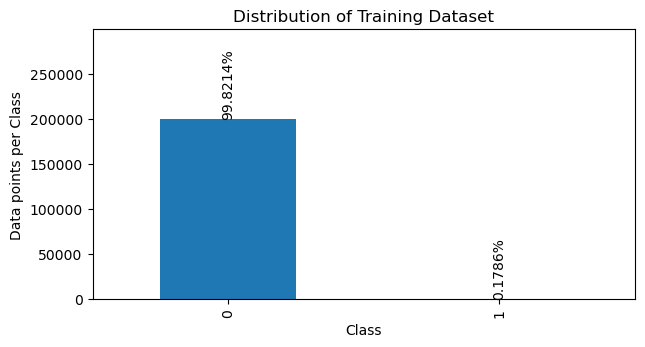

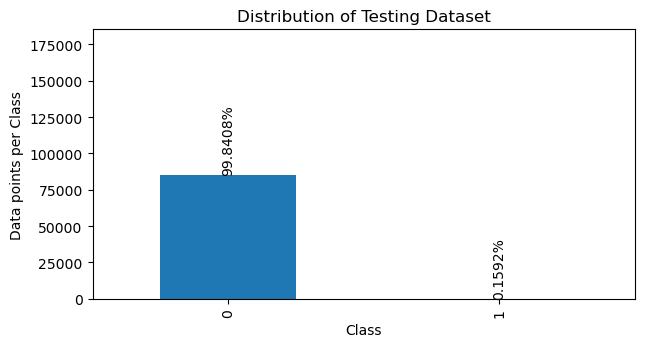

In [7]:
# Separte Features and Class in the Dataset
X = creditcard__dataset.drop('Class', axis=1) 
y = creditcard__dataset['Class'] 

# Splitting the dataset (Training and Testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print('X_train:')
display(X_train)
print('X_test:')
display(X_test)

print('Distribution of Training Dataset:\n', y_train.value_counts())
print('Distribution of Testing Dataset :\n', y_test.value_counts())

y_train_df = y_train.to_frame(name='Label') # Convert Series data to DataFrame  
custom_bar_plot(y_train_df,'Label', 'Distribution of Training Dataset')

y_test_df= y_test.to_frame(name='Label')# Convert Series data to DataFrame
custom_bar_plot(y_test_df,'Label', 'Distribution of Testing Dataset')

Data balanced using SMOTE.
New class distribution:
0    199008
1    199008
Name: Class, dtype: int64


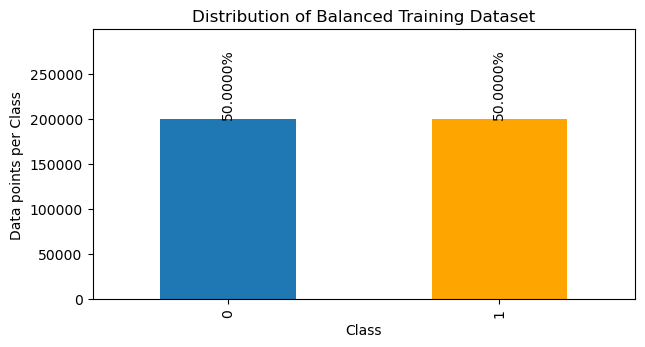

In [8]:
# Balance the Dataset
apply_balancing = True # Set this to False if required 
balancing_method = 'smote'  # Change to 'undersampling' as needed

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
if apply_balancing:
    if balancing_method == 'undersampling':
        # Initialize the RandomUnderSampler
        rus = RandomUnderSampler(random_state=42)
        # Resample the dataset
        X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)
        print("Data balanced using Undersampling.")
    elif balancing_method == 'smote':
        # Initialize SMOTE
        smote = SMOTE(random_state=42)
        # Resample the dataset
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
        print("Data balanced using SMOTE.")
    
    # Reassign resampled data back to X_train and y_train
    X_train = X_train_resampled
    y_train = y_train_resampled

    # Display the new class distribution
    print("New class distribution:")
    print(pd.Series(y_train).value_counts())
    
    y_train_df = y_train.to_frame(name='Label') # Convert Series data to DataFrame  
    custom_bar_plot(y_train_df,'Label', 'Distribution of Balanced Training Dataset')  

In [9]:
# Standardize or Normalize the Numerical Training and Testing Dataset (Default: standardize)
scale_method = 'standardize'  

if scale_method == 'standardize':
    scaler = StandardScaler()
elif scale_method == 'normalize':
    scaler = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
print("X_train_scaled:")
display(X_train_scaled)

X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
print("X_test_scaled:")
display(X_test_scaled)

X_train=X_train_scaled
X_test=X_test_scaled 

X_train_scaled:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-1.747089,-0.020770,-0.675765,0.736017,-1.296028,0.596315,-0.571292,0.692100,-0.264515,1.202912,...,-1.083338,-0.266314,0.969418,0.953249,0.882490,0.468101,-1.841891,0.334632,-0.465750,-0.421322
1,1.373748,0.375813,-1.760016,0.003863,-0.519056,0.408110,1.412596,0.808964,-0.130420,0.602069,...,2.138275,0.274324,-0.122863,-0.928045,-1.454608,-0.843603,1.347378,-0.418859,0.170128,4.889353
2,0.212284,0.075534,-0.702139,0.987151,-1.055531,0.064795,1.404291,0.237966,0.119239,1.496076,...,-0.782271,-0.418278,-0.484220,-0.231887,0.114315,0.721390,1.757776,-0.167230,0.115238,-0.091986
3,-0.377619,0.678099,-0.476456,0.618447,-0.597829,0.368502,0.391497,0.479012,-0.079300,0.563741,...,-0.344699,-0.281368,-0.825881,0.170024,-0.600105,0.168075,0.187453,-0.117081,-0.072339,-0.416961
4,-1.544395,0.245402,-0.318621,0.784395,-1.244842,0.556571,0.780576,0.574709,-0.048720,1.229902,...,-0.049630,-0.301212,-0.533267,-0.081116,-2.488693,-0.420138,1.646042,0.287679,0.430885,-0.259725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398011,-0.923840,-1.348738,0.939509,-1.277645,1.503844,-0.678219,-1.108863,-1.087761,-0.119043,-1.947651,...,-0.113150,-0.576402,0.341096,0.370701,0.236157,0.533294,0.912266,-1.222148,-1.906210,-0.183896
398012,1.584220,-0.786304,-0.455611,-0.280905,-0.105479,0.571770,0.594071,-0.496041,-1.797553,-0.167863,...,-0.514818,-1.501033,1.921316,0.574055,-0.087406,0.959867,2.115682,1.019699,-1.478918,-0.294857
398013,-1.079460,0.621631,-0.332496,0.653662,0.148530,0.323239,0.682099,0.396506,-0.038913,0.154892,...,-0.242458,-0.179949,-0.316588,0.067988,0.080230,0.669053,-0.265198,0.055688,0.071254,-0.412181
398014,1.342250,-0.486054,0.722216,-0.851216,1.725337,0.086748,-0.835230,-0.218831,0.020956,-0.094747,...,-0.368444,0.120064,0.679538,0.543409,-1.058802,-0.511989,0.708069,-3.022853,0.904978,-0.403957


X_test_scaled:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-0.935984,-2.878348,2.066633,-2.644000,2.318023,-3.221883,-1.300177,-2.701705,1.875497,-3.315021,...,-1.822994,0.445837,-1.246666,-2.411265,1.348575,-2.326556,-1.132376,-2.326667,-2.670726,1.195050
1,-0.879248,0.506987,-1.360511,0.570606,-1.192657,0.002392,1.092977,0.409677,-0.061158,1.008314,...,0.365812,-0.267635,-1.045777,-0.501132,-2.057301,0.469116,-1.764332,-0.053108,0.149626,1.889014
2,-1.059935,0.719701,-0.709176,0.623157,-1.077976,0.240536,0.486374,0.373483,-0.120045,0.148182,...,0.048299,-0.107157,0.159474,-0.125541,-1.412127,0.783338,-0.619433,-0.085769,-0.090330,-0.287808
3,1.650038,0.352058,-0.031959,0.304057,-0.858643,0.586827,0.069040,0.563805,0.034958,0.372021,...,-0.447208,0.023189,0.924852,-0.138058,0.063534,-0.371416,-0.453402,-0.360413,-0.096982,-0.419097
4,1.677830,0.843055,-0.572042,0.417518,-0.640494,0.333961,-0.133644,0.518848,-0.163339,0.761739,...,-0.458753,-0.280443,-0.691921,0.410121,0.210029,-0.619075,0.286746,-0.184515,-0.275599,-0.421812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85438,0.776742,0.303635,0.021043,0.220148,-1.084861,0.857672,1.281877,0.466678,-0.583581,0.289119,...,-0.804462,1.005702,-1.031995,0.633424,5.622322,-1.059883,0.109964,-0.063292,0.128753,-0.408015
85439,1.490102,0.865413,-0.550156,0.326956,-0.705506,0.512254,0.237640,0.534428,-0.174209,0.848053,...,-0.352395,-0.333039,-0.976123,0.341385,0.162338,-0.315696,0.359819,-0.181639,-0.249751,-0.417806
85440,-1.133490,0.588676,-0.841483,0.789690,-0.220118,0.069771,1.049571,0.345643,0.007044,1.358927,...,-0.115527,-0.121980,0.040043,-0.197554,-0.756537,0.496694,-0.591445,-0.033948,0.042224,0.444742
85441,1.113145,0.856380,-0.479721,0.294899,-0.615979,0.499629,-0.066368,0.547209,-0.184159,0.815951,...,-0.343626,-0.345868,-1.048542,0.395120,0.997753,-0.435544,0.286665,-0.166680,-0.177896,-0.421812


Scores alongside the feature names (f_classif):
   Feature          Score
0     Time   10547.308283
1       V1   95572.326656
2       V2  157954.319306
3       V3  219628.566738
4       V4  508473.611728
5       V5   68422.118219
6       V6  107801.970934
7       V7  142018.925056
8       V8    5948.652584
9       V9  220081.567147
10     V10  305949.036973
11     V11  395616.496070
12     V12  410237.296280
13     V13       0.060218
14     V14  635681.427518
15     V15     970.936665
16     V16  244638.013242
17     V17  200816.744096
18     V18  119748.917452
19     V19   34612.811797
20     V20   13755.894501
21     V21   10443.499099
22     V22     251.611534
23     V23     929.379325
24     V24    3598.347176
25     V25     543.297473
26     V26    4105.929903
27     V27    3968.609040
28     V28    4196.883680
29  Amount     377.207225


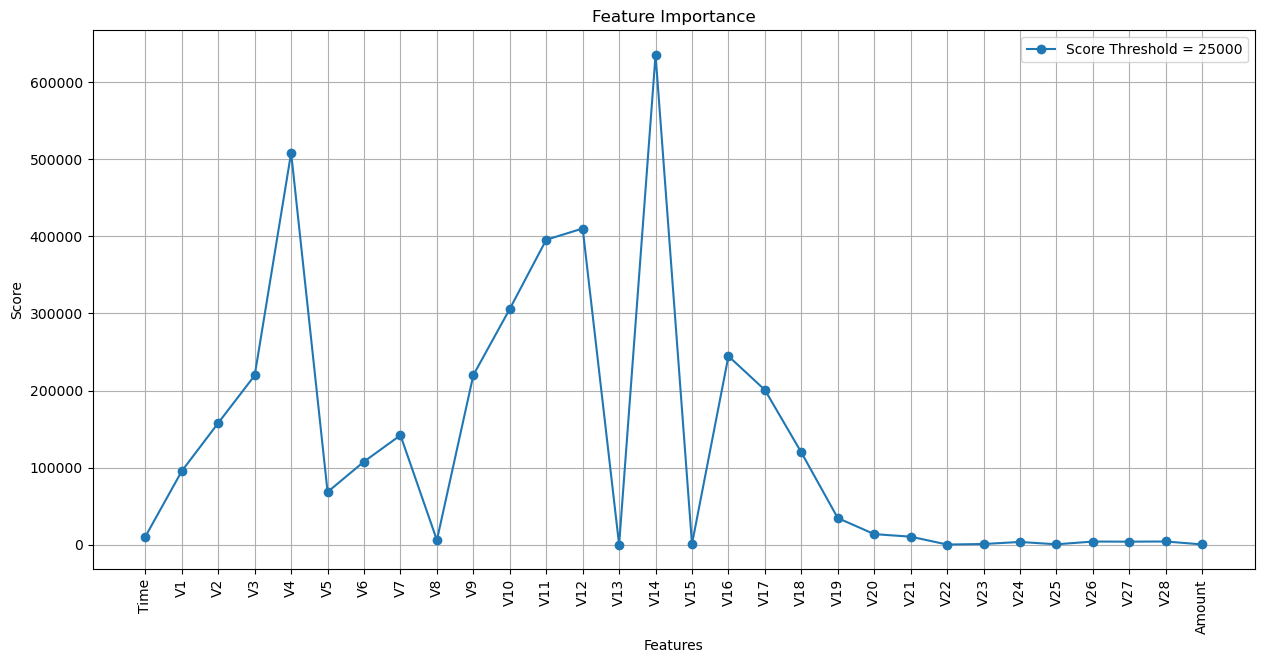

Features selected by score threshold: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'V19']
Final Training dataset after preprocessing:


,V1,V2,V3,V4,V5,V6,V7,V9,V10,V11,V12,V14,V16,V17,V18,V19
0,-0.020770,-0.675765,0.736017,-1.296028,0.596315,-0.571292,0.692100,1.202912,0.554888,-0.582484,0.840471,0.734270,0.345357,0.524573,0.209048,-0.614110
1,0.375813,-1.760016,0.003863,-0.519056,0.408110,1.412596,0.808964,0.602069,0.572518,-0.370650,0.864461,1.018615,0.461977,0.589815,0.081025,-1.013164
2,0.075534,-0.702139,0.987151,-1.055531,0.064795,1.404291,0.237966,1.496076,0.486616,-1.482992,0.032763,0.812096,0.224885,0.747193,1.386004,-0.665560
3,0.678099,-0.476456,0.618447,-0.597829,0.368502,0.391497,0.479012,0.563741,0.626527,-0.187962,0.800943,0.804369,0.771770,0.569355,0.465014,-0.395251
4,0.245402,-0.318621,0.784395,-1.244842,0.556571,0.780576,0.574709,1.229902,0.501776,-0.301375,0.143060,1.128596,0.882921,0.508714,0.689586,-0.671212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398011,-1.348738,0.939509,-1.277645,1.503844,-0.678219,-1.108863,-1.087761,-1.947651,-1.440195,0.973318,-0.909987,-1.404630,-0.756537,-0.619184,-0.782339,0.233207
398012,-0.786304,-0.455611,-0.280905,-0.105479,0.571770,0.594071,-0.496041,-0.167863,-0.183245,-0.150636,0.123499,0.266276,-0.318731,-0.023898,-0.581811,0.364755
398013,0.621631,-0.332496,0.653662,0.148530,0.323239,0.682099,0.396506,0.154892,0.649915,-0.174816,0.793590,0.573300,0.466082,0.335783,0.027556,-0.744768
398014,-0.486054,0.722216,-0.851216,1.725337,0.086748,-0.835230,-0.218831,-0.094747,0.111825,0.882823,-1.208527,-2.163693,-0.658724,-0.402033,-0.054445,0.597243


Final Testing dataset after preprocessing:


,V1,V2,V3,V4,V5,V6,V7,V9,V10,V11,V12,V14,V16,V17,V18,V19
0,-2.878348,2.066633,-2.644000,2.318023,-3.221883,-1.300177,-2.701705,-3.315021,-2.665713,1.247834,-1.717342,-1.284922,-2.361351,-2.801940,-3.214411,2.282463
1,0.506987,-1.360511,0.570606,-1.192657,0.002392,1.092977,0.409677,1.008314,0.524135,-0.736384,0.929500,0.733654,-0.029422,0.599377,1.249525,0.075762
2,0.719701,-0.709176,0.623157,-1.077976,0.240536,0.486374,0.373483,0.148182,0.835418,-0.503777,0.735251,0.727506,1.146937,0.483420,0.244287,0.703829
3,0.352058,-0.031959,0.304057,-0.858643,0.586827,0.069040,0.563805,0.372021,0.332997,-1.193371,0.760159,0.660241,0.764548,0.665291,0.910343,-0.198119
4,0.843055,-0.572042,0.417518,-0.640494,0.333961,-0.133644,0.518848,0.761739,0.718294,-0.357054,0.900510,0.912345,0.642215,0.494189,0.332009,0.052750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85438,0.303635,0.021043,0.220148,-1.084861,0.857672,1.281877,0.466678,0.289119,0.454071,-0.386837,0.998318,0.647050,0.758269,0.661027,0.646906,-0.299660
85439,0.865413,-0.550156,0.326956,-0.705506,0.512254,0.237640,0.534428,0.848053,0.671609,-1.218415,0.766490,0.820770,0.654505,0.472399,0.209472,0.081317
85440,0.588676,-0.841483,0.789690,-0.220118,0.069771,1.049571,0.345643,1.358927,0.582545,-1.349197,0.540455,0.732709,0.576919,0.613591,0.484530,-0.560653
85441,0.856380,-0.479721,0.294899,-0.615979,0.499629,-0.066368,0.547209,0.815951,0.567493,-0.923970,0.751986,0.589977,0.713068,0.655735,0.345179,-0.221856


In [10]:
# Feature Selection
apply_feature_selection = True  # Set this to False if required 
pd.set_option('display.max_rows', None)

if apply_feature_selection:
    selector_f_classif = SelectKBest(score_func=f_classif, k='all')  # Use all features to compute scores
    selector_f_classif.fit_transform(X_train, y_train)

    # Create a DataFrame to view the scores alongside the feature names
    feature_scores = pd.DataFrame({'Feature': X_train.columns, 'Score': selector_f_classif.scores_})
    print("Scores alongside the feature names (f_classif):")
    print(feature_scores)
    
    score_threshold = 25000  # Adjust this threshold based on your specific needs

    # Plot the scores to visualize their distribution
    plt.figure(figsize=(15, 7))
    plt.plot(feature_scores['Feature'], feature_scores['Score'], marker='o')
    plt.xticks(rotation=90)  # Rotate feature names for better readability
    plt.xlabel('Features')
    plt.ylabel('Score')
    plt.title('Feature Importance')
    plt.grid(True)
    plt.legend([f'Score Threshold = {score_threshold}'])  # Add legend with score threshold
    plt.show()

    # Filter features by score threshold
    high_score_features = feature_scores[feature_scores['Score'] > score_threshold]['Feature']
    print("Features selected by score threshold:", list(high_score_features))

    # Update X_train and X_test to include only the selected features
    X_train = X_train[high_score_features]
    X_test = X_test[high_score_features]

pd.reset_option('display.max_rows')

print('Final Training dataset after preprocessing:')
display(X_train)

print('Final Testing dataset after preprocessing:')
display(X_test)

best_model: RandomForestClassifier(random_state=42)


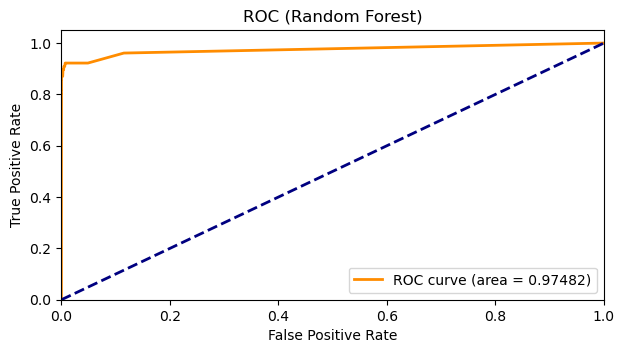

In [11]:
#Train, Validate, and Select the best Mode

# Splitting the Test Data into Validation and Final Test Sets
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

use_param_grid = False # Set this to False if required 

# Define the model and hyperparameter grid
model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
} if use_param_grid else {}

# Set up GridSearchCV with or without a parameter grid
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc') if use_param_grid else GridSearchCV(model, {}, cv=5, scoring='roc_auc')

grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_model = grid_search.best_estimator_

print('best_model:', best_model)

# Predict probabilities on the validation set
y_prob_val = best_model.predict_proba(X_val)[:, 1]

# Calculate ROC and AUC
fpr, tpr, thresholds = roc_curve(y_val, y_prob_val)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(7, 3.5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.5f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (Random Forest)')
plt.legend(loc="lower right")
plt.show()

Optimal threshold based on Youden's J statistic: 0.08


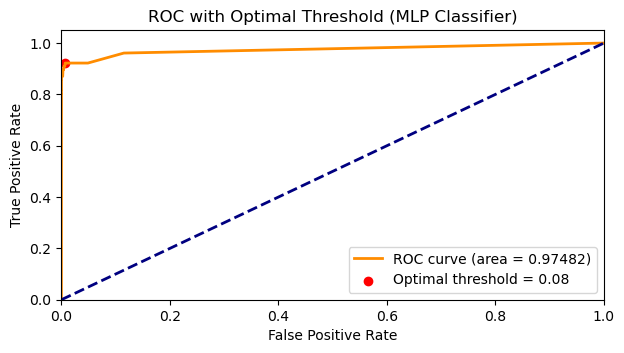

In [12]:
# Determining and Visualizing the Optimal Threshold on the ROC Curve Using Youden's J Statistic
use_optimal_threshold = True  # Set this to False to use a default threshold of 0.5
optimal_threshold = 0.5  # Default threshold

if use_optimal_threshold:
    # Calculate Youden's J statistic to find the optimal threshold
    j_scores = tpr - fpr
    optimal_idx = np.argmax(j_scores)
    optimal_threshold = thresholds[optimal_idx]
    print(f'Optimal threshold based on Youden\'s J statistic: {optimal_threshold:.2f}')
    
    # Plot the ROC curve
    plt.figure(figsize=(7,3.5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.5f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f'Optimal threshold = {optimal_threshold:0.2f}')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC with Optimal Threshold (MLP Classifier)')
    plt.legend(loc="lower right")
    plt.show()

In [13]:
# Model Performance Evaluation on Test Set Using Optimal Threshold
y_prob_test = best_model.predict_proba(X_test)[:, 1]
y_pred_test = (y_prob_test >= optimal_threshold).astype(int)

accuracy = accuracy_score(y_test, y_pred_test)
print(f'Accuracy: {accuracy}')

report = classification_report(y_test, y_pred_test)  
print(f'Classification Report:\n{report}')

Accuracy: 0.9930246711296288
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     42663
           1       0.16      0.95      0.27        59

    accuracy                           0.99     42722
   macro avg       0.58      0.97      0.63     42722
weighted avg       1.00      0.99      1.00     42722



Class distribution in y_test:
0    42663
1       59
Name: Class, dtype: int64
conf_matrix:
[[42368   295]
 [    3    56]]


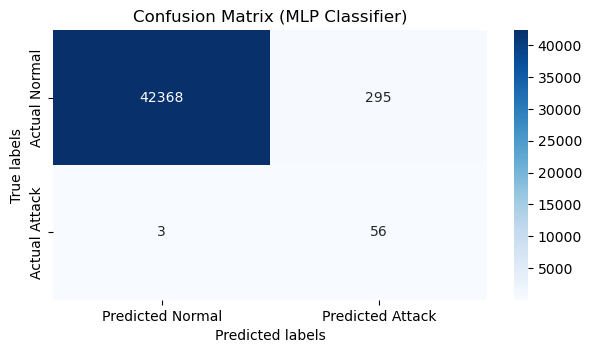

In [14]:
# Class Distribution and Confusion Matrix Analysis for Model Evaluation
class_counts = y_test.value_counts()
print("Class distribution in y_test:")
print(class_counts)

# Calculate and visualize the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)
print("conf_matrix:")
print(conf_matrix)

plt.figure(figsize=(7,3.5))

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Normal', 'Predicted Attack'],
            yticklabels=['Actual Normal', 'Actual Attack'])

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix (MLP Classifier)')
plt.show()